In [8]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

from sklearn.preprocessing import OneHotEncoder

from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

sns.set_palette("Set2")

# Introduction
In this notebook, we are going to explore three supervised learning models and their respective hyperparameters; These models are: **Decision Tree**, **K-Nearest Neighbors** and **Support Vector Machine**. The first section will consist of an Exploratory Data Analysis and feature selection. The second section will be about training the models, their hyperparameters and then comparing the three models together. After which, we will select the best model and submit our results to Kaggle.

# The Dataset
You can find the dataset we used here: https://www.kaggle.com/competitions/spaceship-titanic/overview 
It is a spinoff on the classic Titanic Dataset, but with far more rows and attributes. It involves a ficticious spaceship that experiences a catastrophe where passengers were transported to an alternate dimension. Each entry has information on the type of passenger, their home planet, destination, VIP status and more. We are going to use these attributes to predict whether someone was transported or not.

This dataset is ideal because it has minimal categorical variables to encode and is easy to understand, so we can spend more time and energy working with the model and hyperparameters.

In [9]:
#Load the data and drop any rows with null values
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
train.dropna(inplace=True)
test.dropna(inplace=True)

In [10]:
# The Cabin and Passenger columns include dense information. Cabins have a deck, number and side while passengers have group.
# We are splitting this information into different columns.

train['Cabin'] = train['Cabin'].fillna(method='bfill')
train['Cabin Deck'] = train['Cabin'].apply(lambda x: x.split('/')[0])
train['Cabin Num'] = train['Cabin'].apply(lambda x: x.split('/')[1])
train['Cabin Side'] = train['Cabin'].apply(lambda x: x.split('/')[2])
train[["FirstName","LastName"]] = train['Name'].str.split(' ', 1, expand=True)
train['Total Spent'] = train['RoomService'] + train['FoodCourt'] + train['ShoppingMall'] + train['Spa']
train['Group'] = train['PassengerId'].apply(lambda x: x.split('_')[0])

test['Cabin'] = test['Cabin'].fillna(method='bfill')
test['Cabin Deck'] = test['Cabin'].apply(lambda x: x.split('/')[0])
test['Cabin Num'] = test['Cabin'].apply(lambda x: x.split('/')[1])
test['Cabin Side'] = test['Cabin'].apply(lambda x: x.split('/')[2])
test[["FirstName","LastName"]] = test['Name'].str.split(' ', 1, expand=True)
test['Total Spent'] = test['RoomService'] + test['FoodCourt'] + test['ShoppingMall'] + test['Spa']
test['Group'] = test['PassengerId'].apply(lambda x: x.split('_')[0])

train.drop('PassengerId', axis =1, inplace = True)
test.drop('PassengerId', axis = 1, inplace = True)

In [11]:
print("Num rows: ", train.shape[0])
print("Num features: ", train.shape[1])

Num rows:  6606
Num features:  20


In [12]:
# List of attributes
train.columns

Index(['HomePlanet', 'CryoSleep', 'Cabin', 'Destination', 'Age', 'VIP',
       'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'Name',
       'Transported', 'Cabin Deck', 'Cabin Num', 'Cabin Side', 'FirstName',
       'LastName', 'Total Spent', 'Group'],
      dtype='object')

# Exploratory Data Analysis

<AxesSubplot:xlabel='Cabin Side', ylabel='count'>

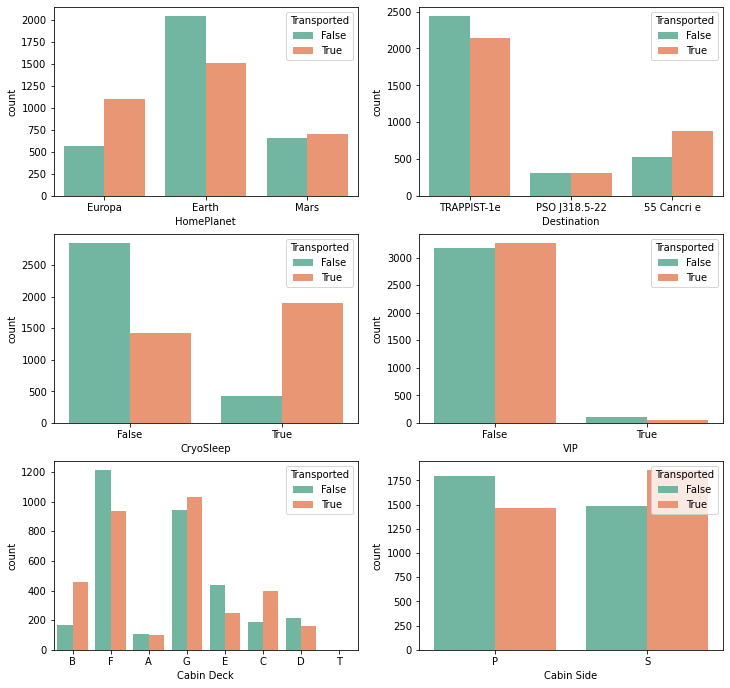

In [13]:
plt.figure(figsize=(12,16))

plt.subplot(4,2,1)
sns.countplot(x="HomePlanet", data=train, hue="Transported")
plt.subplot(4,2,2)
sns.countplot(x="Destination", data=train, hue="Transported")
plt.subplot(4,2,3)
sns.countplot(x="CryoSleep", data=train, hue="Transported")
plt.subplot(4,2,4)
sns.countplot(x="VIP", data=train, hue="Transported")
plt.subplot(4,2,5)
sns.countplot(x="Cabin Deck", data=train, hue="Transported")
plt.subplot(4,2,6)
sns.countplot(x="Cabin Side", data=train, hue="Transported")

<AxesSubplot:xlabel='Age', ylabel='Count'>

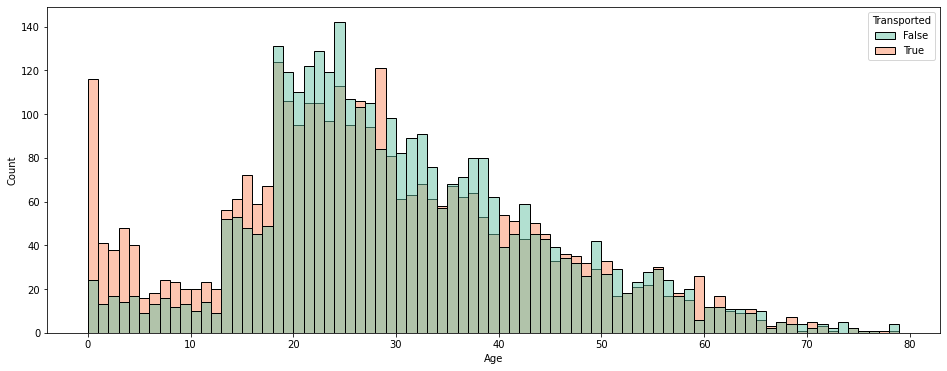

In [14]:
plt.figure(figsize=(16,6))

sns.histplot(data=train, x='Age', hue='Transported', binwidth=1)

## Results of Exploratory Data Analysis
 Passengers between ages 0 to 20 were far more likely to be transported. Cabin Decks A, C and G and Cabin Side S had more transported passengers. Passengers in Cryosleep are far more likely to be transported. Home Planet and Destination do not have a significant influence on transport numbers. VIP status does; there are far less VIPs who were transported than otherwise.

# Feature Selection
We are going to use the results of the EDA to select features. 

In [15]:
# Encoding categorical variables into one-hot vectors and dropping features that will not aid in prediction.
train.drop(['Name', 'FirstName', 'LastName', 'Total Spent'], axis=1)
train_OH_encodings = pd.get_dummies(train[['HomePlanet','Destination','Cabin Deck','Cabin Side']])
test_OH_encodings = pd.get_dummies(test[['HomePlanet','Destination','Cabin Deck','Cabin Side']])

train.drop(['HomePlanet','Destination','Cabin Deck','Cabin Side'], axis = 1, inplace = True)
test.drop(['HomePlanet','Destination','Cabin Deck','Cabin Side'], axis = 1, inplace = True)
train.drop(['Name', 'FirstName', 'LastName', 'Total Spent', 'Cabin'], axis = 1, inplace = True)
test.drop(['Name', 'FirstName', 'LastName', 'Total Spent', 'Cabin'], axis = 1, inplace = True)

train = train.join(train_OH_encodings)
test = test.join(test_OH_encodings)

In [16]:
# Changing booleans into ints
train['CryoSleep'] = train['CryoSleep'].astype(int)
train['VIP'] = train['VIP'].astype(int)
train['Transported'] = train['Transported'].astype(int)
test['CryoSleep'] = test['CryoSleep'].astype(int)
test['VIP'] = test['VIP'].astype(int)

### The features we will use:

In [17]:
train.columns

Index(['CryoSleep', 'Age', 'VIP', 'RoomService', 'FoodCourt', 'ShoppingMall',
       'Spa', 'VRDeck', 'Transported', 'Cabin Num', 'Group',
       'HomePlanet_Earth', 'HomePlanet_Europa', 'HomePlanet_Mars',
       'Destination_55 Cancri e', 'Destination_PSO J318.5-22',
       'Destination_TRAPPIST-1e', 'Cabin Deck_A', 'Cabin Deck_B',
       'Cabin Deck_C', 'Cabin Deck_D', 'Cabin Deck_E', 'Cabin Deck_F',
       'Cabin Deck_G', 'Cabin Deck_T', 'Cabin Side_P', 'Cabin Side_S'],
      dtype='object')

# Models
To find the best hyperparameters, we will be using Grid Search and Cross Validation. This will allow us to try every possible combination of hyperparamters and train/validation splits. For each model, we'll have a table showing the scores for each hyperparamater permutation and the mean score for their cross validation splits. We will also go into detail on how each model works and what effect their hyperparameters have on them.

In [18]:
features = list(train.columns)
features.remove('Transported')
X = train[features]
y = train['Transported']
train_X, val_X, train_y, val_y = train_test_split(X, y)

# Decision Tree

In [37]:
#Decision Tree

hyperparameters = {
    'max_depth': [2,3,5,10],
    'min_samples_leaf': [5,10],
    "max_leaf_nodes":[None,10,20],
}

dt = DecisionTreeClassifier()
dt_clf = GridSearchCV(dt, hyperparameters, cv=10, n_jobs=-1)
dt_model = dt_clf.fit(train_X, train_y)

dt_model_scores = pd.DataFrame(dt_model.cv_results_)
dt_model_scores = dt_model_scores.style.set_caption('Top 10 Fields of Research by Aggregated Funding Amount')
dt_score_columns = ['param_max_depth', 'param_max_leaf_nodes', 'param_min_samples_leaf', 'mean_test_score']
test=dt_model_scores[dt_score_columns].sort_values('mean_test_score', ascending=False, ignore_index=True)
test.style.set_table_attributes("style='display:inline'").set_caption('Caption table')

TypeError: 'Styler' object is not subscriptable

# K-Nearest Neighbors

In [33]:
#K-nearest neighbors

hyperparameters = {
    'leaf_size': [1,2,3],
    'n_neighbors': [1,2,3],
    "p":[1,2],
}

knn = KNeighborsClassifier()
knn_clf = GridSearchCV(knn, hyperparameters, cv=10, n_jobs=-1)
knn_model = knn_clf.fit(train_X, train_y)

knn_model_scores = pd.DataFrame(knn_model.cv_results_)
knn_score_columns = ['param_leaf_size', 'param_n_neighbors', 'param_p', 'mean_test_score']
knn_model_scores[knn_score_columns].sort_values('mean_test_score', ascending=False, ignore_index=True)

# Support Vector Machine
The Support Vector Machine (SVM) algorithm's goal is to find an N-dimensional hyperplane that classifies the data. The hyperplane's geometry depends on dimensionality; a dataset with two attributes would have a hyperplane of a line, three attributes a plane and etc. There are many viable hyperplanes that can classify a data set, so we look for one that has the maximizes the amount of margin: the maximum distance between data points of both classes. By maximizing the margin, we create a buffer for future predictions and minimize overfitting.


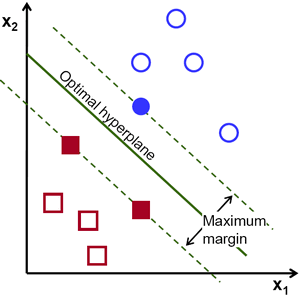

### Hyperparameters
#### Kernel
The most influential hyperparameter for SVM is the kernel. Three most commonly used kernels are the linear, polynomial and radial kernels. The choice of kernel determines the shape of the hyperplane. Remember that the hyperplane divides the data points into different classifications. The shape of the hyperplane is determined by the kernel; it can be linear, polynomial or radial. Below is an example on how the different kernels change the hyperplane's shape to divide a dataset into three different classifications.
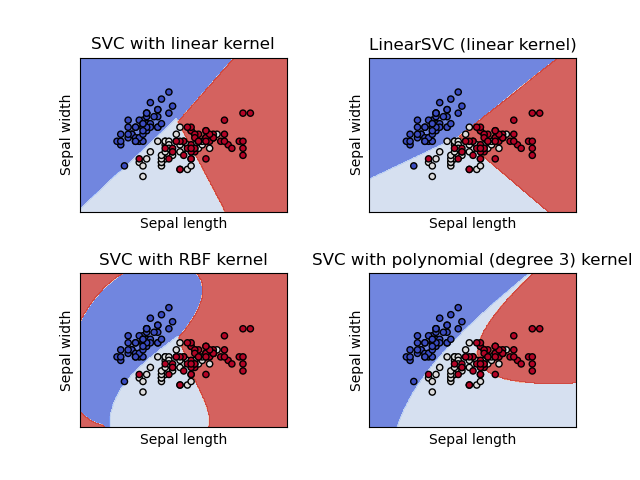


#### C
C stands for cost, which determines how much the penalty for having data points inside the margin. If C is small, then it's more acceptable to have data points inside the margin which indirectly creates a wider margin. If C is large, then the margin will be far more narrow as it is less tolerant of misclassified ponts. If your dataset has a lot of noise, or classifications in reality are not quite strict, you should set C to be small to prevent overfitting. In contrast, if your dataset is quality and classifications are strict, a high C value will allow the model to better represent reality.


#### Gamma
Gamma controls how much influence a data point has in determining the position of the hyperplane. If Gamma is high, each individual point has more power to adjust the hyperplane. Of course, lower Gamma's cause points to have less power. Gamma determines how complicated the hyperplane function will be. The higher the Gamma, the more complicated the hyperplane will be. Essentially, if data points of the same classification are tightly clustered, a low Gamma can capture it. In contrast, if data points are more "cloudy" and vague, a higher Gamma is more suitable.


Note that the linear kernel does not utilize the Gamma hyperparameter.

### Grid Search with Cross Validation
Let's see what are the top 10 best hyperparameter combinations are for SVM.

In [ ]:
#SVM

hyperparameters = {
    'kernel': ['linear', 'poly', 'rbf'],
    'C': [0.1, 1, 10, 100, 1000],
    'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
}

svc = SVC()
svc_clf = GridSearchCV(svc, hyperparameters, cv=10, n_jobs=-1)
svc_model = svc_clf.fit(train_X, train_y)

svc_model_scores = pd.DataFrame(svc_model.cv_results_)
svc_score_columns = ['param_C', 'param_gamma', 'param_kernel', 'mean_test_score']
svc_model_scores[svc_score_columns].sort_values('mean_test_score', ascending=False, ignore_index=True).head(10)